In [23]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

import warnings
warnings.filterwarnings('ignore')

In [24]:
if parse_version(matplotlib.__version__) >= parse_version("2.1"):
    density_param = {"density": True}
else:
    density_param = {"normed": True}

## 常用的核函数

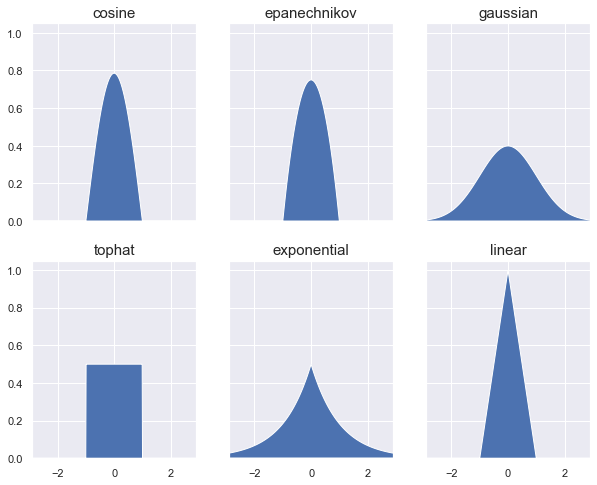

In [36]:
# Plot all available kernels
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=[10,8])

for i, kernel in enumerate(
    ["cosine", "epanechnikov", "gaussian", "tophat",  "exponential", "linear"]
):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens))
    axi.set_title(kernel,fontsize=15)
    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

## 绘制概率密度图

In [25]:
# 绘制各种分布图
def plot_kde(X,bins_=50):
    X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
    bins = np.linspace(-5, 10, bins_)
    # 可视化
    _, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=[20,15])
    kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]
    # histogram 1
    ax[0, 0].hist(X[:, 0], bins=bins, **density_param)
    ax[0, 0].set_title('histogram',fontsize=15)
    # histogram shift
    ax[0, 1].hist(X[:, 0], bins=bins, **density_param)
    ax[0, 1].set_title('histogram shift',fontsize=15)
    # kde
    for kernel,ax_ in zip(kernels,ax.ravel()[2:]):
        kde = KernelDensity(kernel=kernel, bandwidth=0.75).fit(X)
        log_dens = kde.score_samples(X_plot)
        ax_.fill(X_plot[:, 0], np.exp(log_dens))
        ax_.set_title(kernel+' KDE',fontsize=15)
        # 绘制散点
        ax_.plot(X[:, 0], np.full(X.shape[0], -0.01), "+k")
    # 绘制坐标
    for axi in ax[:, 0]:
        axi.set_ylabel("Normalized Density")
    for axi in ax[2, :]:
        axi.set_xlabel("x")


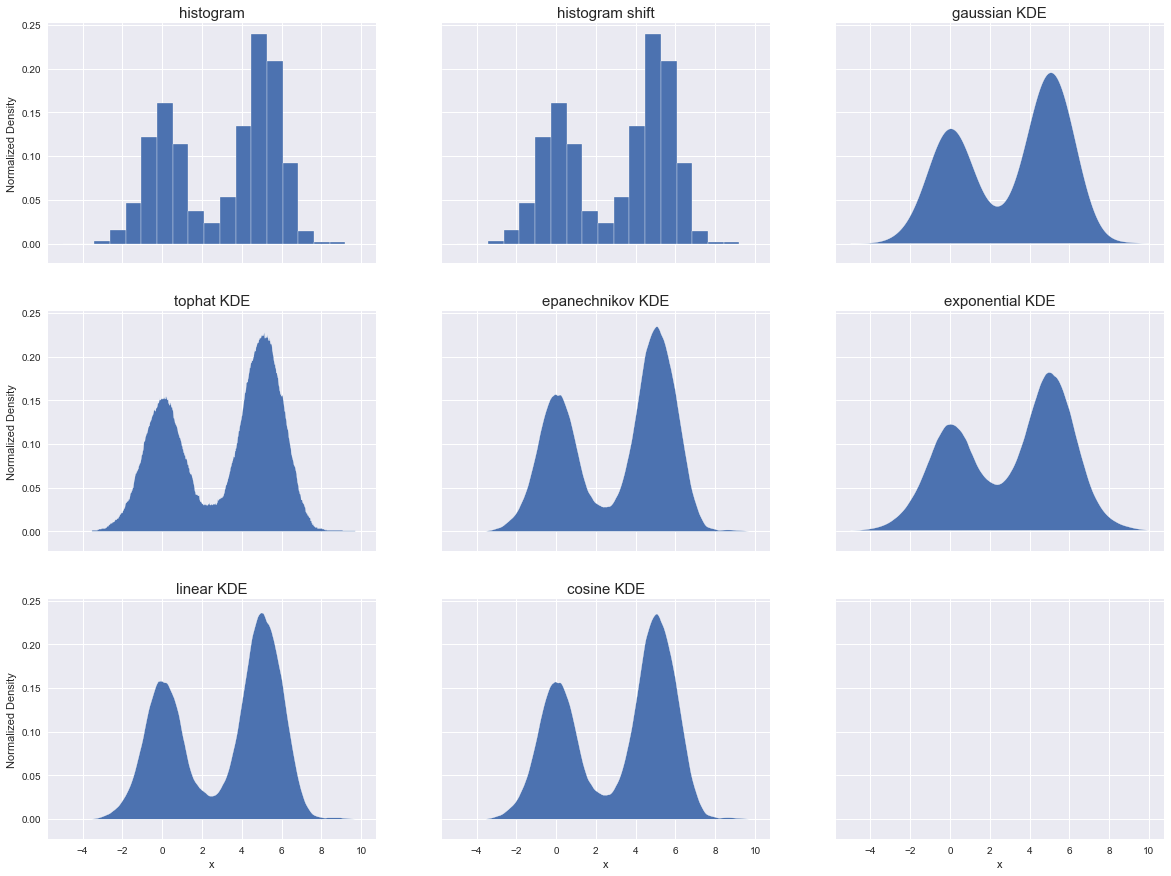

In [78]:
# 服从三峰分布的随机样本
np.random.seed(1)
N = 1000
X = np.concatenate(
    (np.random.normal(0, 1, int(0.4 * N)), 
    np.random.normal(5, 1, int(0.6 * N))
    )
)[:, np.newaxis]
# 绘制分布图
plot_kde(X,bins_=20)

## 核密度估计函数的差异比较

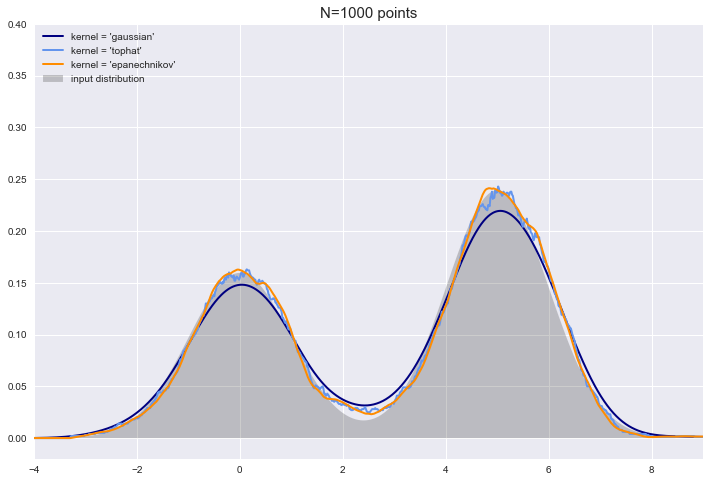

In [79]:
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
# 真实分布函数
true_dens =  0.4 * norm(0, 1).pdf(X_plot[:, 0]) +\
         0.6 * norm(5, 1).pdf(X_plot[:, 0])
# 可视化
fig, ax = plt.subplots(figsize=[12,8])
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

ax.set_title("N={0} points".format(N),fontsize=15)

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

In [10]:
# kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
# X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
# log_dens = kde.score_samples(X_plot)

##  RSP数据块的划分

In [106]:
data=X.copy()
'''
先按HDFS数据块划分，再划分为RSP数据块
'''
K=10 # HDFS数据块个数
M=5 # RSP数据块个数
# 按顺序切分为k份
HDFS=np.array(np.split(data,K))
for i in range(HDFS.shape[0]):
    np.random.shuffle(HDFS[i])
HDFS_list=[np.split(D_k,M) for D_k in HDFS]
print('HDFS: [块数: {0} 块内元素个数: {1} 数据块维度: {2}]'.format(
    HDFS.shape[0],HDFS.shape[1],HDFS.shape[2]))

HDFS: [块数: 10 块内元素个数: 100 数据块维度: 1]


In [107]:
# 划分RSP
RSP=[[D_K[m] for D_K in HDFS_list] for m in range(M)]
for idx,RSP_ in enumerate(RSP):
    tmp_RSP=RSP_[0]
    for i in range(1,len(RSP_)):
        tmp_RSP=np.vstack((tmp_RSP,RSP_[i]))
    RSP[idx]=tmp_RSP
RSP=np.array(RSP)
print('RSP: [块数: {0} 块内元素个数: {1} 数据块维度: {2}]'.format(
    RSP.shape[0],RSP.shape[1],RSP.shape[2]))


RSP: [块数: 5 块内元素个数: 200 数据块维度: 1]


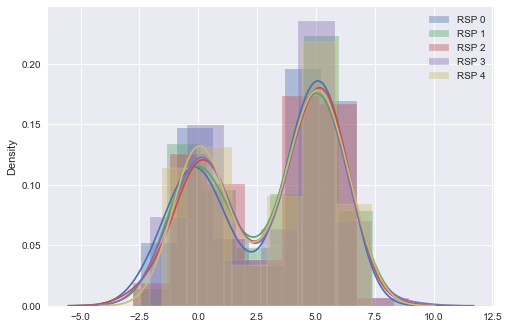

In [108]:
sns.set_style('darkgrid')
for i in range(5):
    sns.distplot(RSP[i,:,:], label='RSP '+str(i))
plt.legend()
# sns.displot(RSP_df, kde = True, alpha=0.3)

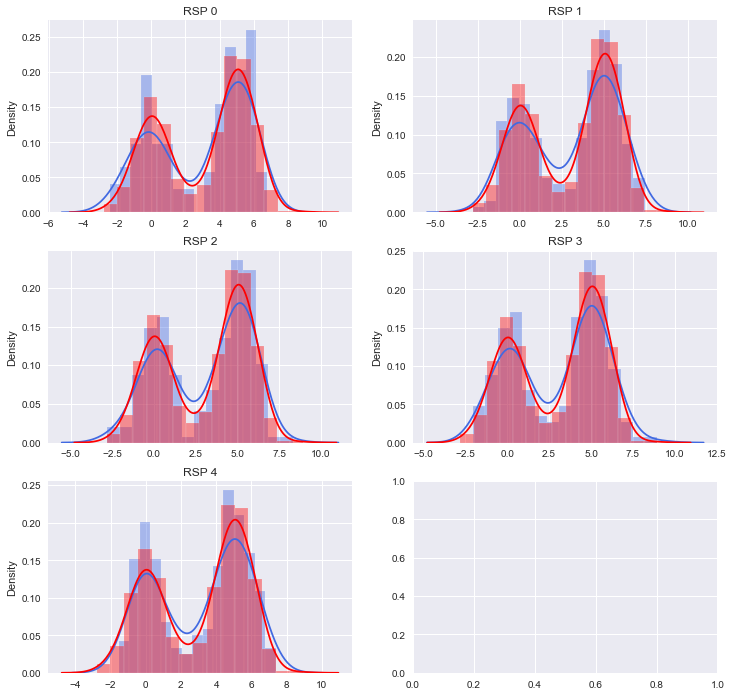

In [118]:
plt.style.use('seaborn')
fig,axes = plt.subplots(ncols=2,nrows=3,figsize=[12,12])
for i,ax_ in enumerate(axes.flat[:5]):
    ax_.set_title('RSP '+str(i))
    ax.legend()
    # RSP
    sns.distplot(RSP[i,:,:],kde=True,ax=ax_,color='royalblue',bins=15,label='RSP')
    # 总体
    sns.distplot(X,kde=True,ax=ax_,color='red',bins=15,label='total')

## RSP的核密度估计函数f

In [119]:
num_RSP = M
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
RSP_samples = []
for i in range(num_RSP):
    kde_ = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(RSP[i,:,:])
    RSP_samples.append(np.exp(kde_.score_samples(X_plot)))
RSP_samples=np.array(RSP_samples)
RSP_kernel = RSP_samples.mean(axis=0)

##  总体的核密度估计

In [120]:
# 总体的核密度估计
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
total_kernel = np.exp(kde.score_samples(X_plot))

##  比较差异

In [121]:
import scipy.stats  
def KL_divergence(p,q):  
    return scipy.stats.entropy(p, q)  

In [143]:
differ = KL_divergence(RSP_kernel, total_kernel)

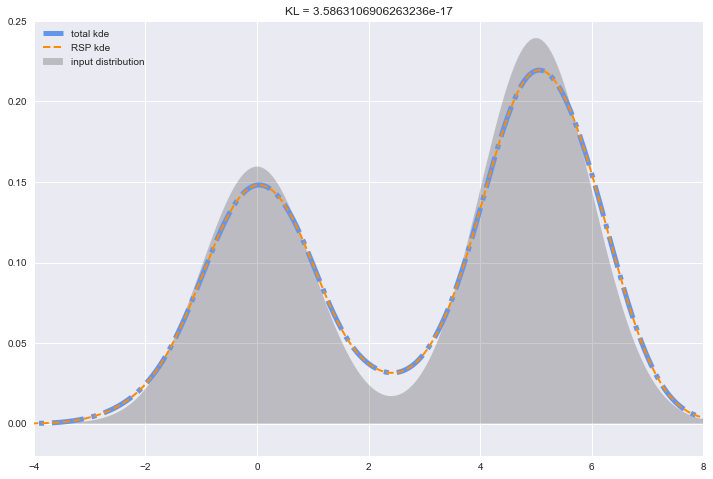

In [146]:
# 可视化
fig, ax = plt.subplots(figsize=[12,8])
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

# 真实分布函数
true_dens =  0.4 * norm(0, 1).pdf(X_plot[:, 0]) + 0.6 * norm(5, 1).pdf(X_plot[:, 0])
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")

# 总体
ax.plot(
    X_plot[:,0],
    total_kernel,
    color = "cornflowerblue",
    lw = 5,
    linestyle='-.',
    label = 'total kde'
)

# RSP
ax.plot(
    X_plot[:,0],
    RSP_kernel,
    color = "darkorange",
    lw = 2,
    linestyle='--',
    marker='|',
    label = 'RSP kde'
)

ax.legend(loc="upper left")

ax.set_xlim(-4, 8)
ax.set_ylim(-0.02, 0.25)
ax.set_title('KL = '+str(differ))
plt.show()